In [9]:
from keras.applications.resnet50 import decode_predictions
from keras.applications.resnet50 import preprocess_input
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image

from sklearn.feature_selection import VarianceThreshold
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt 
from PIL import Image 
import seaborn as sns
import pandas as pd 
import numpy as np 
import shutil
import os, glob
from os import listdir

In [10]:
# In this code we use pre-trained models for feature extraction, 
# The extracted features will then be used for Machine Learning purposes 

# First step is to load the weights of the pre-trained model in the model architecture. 

# Notice, that an additional argument is passed include_top = False, 
# which states that we do not want to add the last layer of this architecture. 


resnet50 = ResNet50(weights='imagenet', include_top=False)

In [11]:
#The next step is to pass an image to this model and extract the features. 

def _get_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    resnet_features = resnet50.predict(img_data)
    return resnet_features

#Example image to try the function created above
img_path = "C://Users/karim/Desktop/Person/383.png"
resnet_features = _get_features(img_path)

In [12]:
# The extracted features are stored in the variable resnet_features. 
# One can flatten them or sequee them in order to use them in ML models.  

# Flatten will produce a long vector of feature elements. 
features_representation_1 = resnet_features.flatten()

# Squeeze will produce a 3D matrix of the features
features_representation_2 = resnet_features.squeeze()

print ("Shape 1: ", features_representation_1.shape)
print ("Shape 2: ", features_representation_2.shape)

Shape 1:  (100352,)
Shape 2:  (7, 7, 2048)


In [13]:
# We will now create a dataset containing two classes of images : Person and Background. 
# Then we use a third class which will be the general AMLS_Dataset

basepath = "C://Users/karim/Desktop/"          #MAKE SURE TO CHANGE THE DIRECTORY TO RUN THE CODE
class1 = os.listdir(basepath + "Person/")      #MAKE SURE TO CREATE THESE FILES TO RUN THE CODE
class2 = os.listdir(basepath + "Background/")
class3 = os.listdir(basepath + "test/")

# print(class1[:20])
# print(class2[:20])
# print(class3[:20])

#Storing the data
data = {'Person': class1[:20], 
        'Background': class2[:20], 
        'test': class3[:5000]}

#data.items()

In [14]:
# Below, we iterate in the images, call the same function used earlier for image feature 
# extraction, and use the flattened representation of the features

features = {"Person" : [], "Background" : [], "test" : []}
testimgs = []
for label, val in data.items():
    #print(label)
    #print(val)
    for k, img_file in enumerate(val):  
        #print(k)
        #print(img_file)
        
        if label == "test":
            img_path = basepath + label.title() + "/" + img_file
            testimgs.append(img_path)
        else: 
            img_path = basepath + label.title() + "/" + img_file
        #TRY PRINT feats
        feats = _get_features(img_path)
        #print(feats)
        features[label].append(feats.flatten())  
        

In [15]:
# The next step is to convert the features from a dictionary format to pandas dataframe. 
# A long dataframe will be created. Once this step is done, we will be applying a variance filter later
# on this dataframe to reduce the dimentionality. 
# Another idea to avoid this step could be to perform PCA / SVD to obtain the dense features. 

dataset = pd.DataFrame()
for label, feats in features.items():
    temp_df = pd.DataFrame(feats)
    temp_df['label'] = label
    dataset = dataset.append(temp_df, ignore_index=True)
dataset.head()
#print(features)

,0,1,2,3,4,5,6,7,8,9,...,100343,100344,100345,100346,100347,100348,100349,100350,100351,label
0,0.0,0.0,0.0,2.156549,0.028782,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Person
1,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Person
2,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Person
3,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Person
4,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Person


In [16]:
#Prepare X (predictors) and y (target) from the dataset

y = dataset[dataset.label != 'test'].label
X = dataset[dataset.label != 'test'].drop('label', axis=1)

#print(y)
#print(X)

In [17]:
# Here we write a simple neural network (Multi layer Perceptron classifier) 
# using sklearn for training purposes. 

model = MLPClassifier(hidden_layer_sizes=(100, 10))
pipeline = Pipeline([('low_variance_filter', VarianceThreshold()), ('model', model)])
pipeline.fit(X, y)

print ("Model Trained on pre-trained features")

Model Trained on pre-trained features


In [11]:
#MLPClassifier.summary()

c:\users\karim\anaconda3\envs\py36\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


<Figure size 432x288 with 0 Axes>

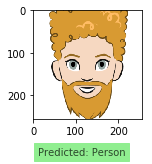

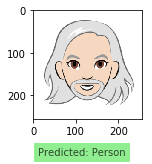

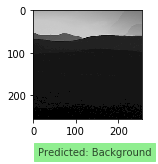

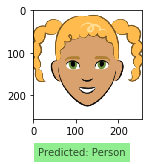

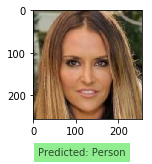

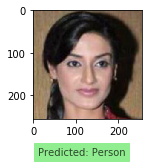

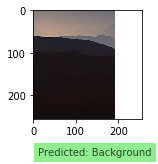

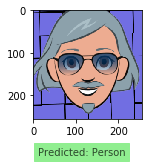

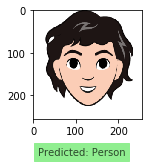

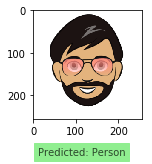

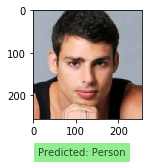

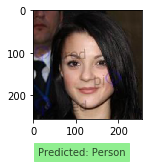

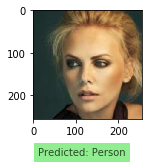

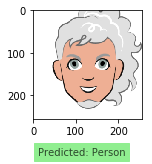

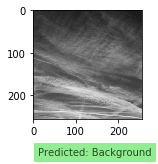

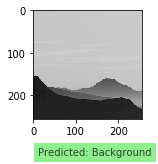

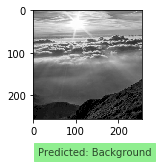

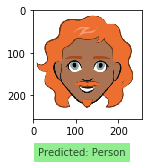

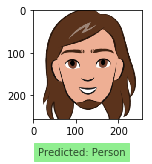

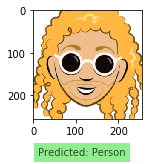

In [12]:
#SMALL TRIAL IN ORDER TO DISPLAY THE IMAGES BEFORE APPLYING IT TO THE GENERAL DATASET

#Now we can predict the output on all the images of the dataset and check the outcome

#Destination of noise images, MAKE SURE TO CHANGE IT IN ORDER TO RUN CODE
destination = 'C://Users/karim/Desktop/noise_pics/'

#Creation of predictions
preds = pipeline.predict(features['test'])

noise_images = []

plt.tight_layout()

for i in range(20):
    #f, ax = plt.subplots(1, 1,figsize=(2,2))
    #ax.imshow(Image.open(testimgs[i]).resize((256, 256), Image.ANTIALIAS),  interpolation = 'none')
    #print(str(testimgs[i]))
    ax.text(10, 340, 'Predicted: %s' % preds[i], color='k', backgroundcolor='lightgreen', alpha=0.7)
    #print(preds[i])
    
    if preds[i] == 'Background':
        exists = os.path.isfile(str(testimgs[i]))
        if exists:
            
            #Record all noise images number to remove them later from attribute list
            image = testimgs[i].split('/')
            noise_images.append(image[6])
            
            #Record file, copy it and then delete it
            file = str(testimgs[i])
            shutil.copy(file,destination)
            os.remove(str(testimgs[i]))
                            

    
plt.show()

In [18]:
#Now we can predict the output on all the images of the dataset and check the outcome

#Destination of noise images, MAKE SURE TO CHANGE IT IN ORDER TO RUN CODE
destination = 'C://Users/karim/Desktop/noise_pics/'

#Creation of predictions
preds = pipeline.predict(features['test'])

noise_images = []

plt.tight_layout()

for i in range(5000):
    
    if preds[i] == 'Background':
        exists = os.path.isfile(str(testimgs[i]))
        if exists:
            
            #Record all noise images number to remove them later from attribute list
            image = testimgs[i].split('/')
            noise_images.append(image[6])
            
            #Record file, copy it and then delete it
            file = str(testimgs[i])
            shutil.copy(file,destination)
            os.remove(str(testimgs[i]))
                            

    
plt.show()

<Figure size 432x288 with 0 Axes>

In [13]:
# Import the data set that include the attribute for each picture
df_attr = pd.read_csv('attribute_list.csv')
df_attr.set_index('file_name', inplace=True)
#df_attr.replace(to_replace=-1, value=0, inplace=True) #replace -1 by 0
df_attr.shape

(5000, 5)

In [14]:
#df_attr

In [15]:
# When changing the directory of images, please re-evaluate the following 
# to choose the right number between the square brackets
img = testimgs[1].split('/')
img
#img[6]

['C:', '', 'Users', 'karim', 'Desktop', 'Test', '10.png']

In [19]:
noise_images

['1031.png',
 '1036.png',
 '1064.png',
 '1065.png',
 '1080.png',
 '1094.png',
 '11.png',
 '1100.png',
 '1114.png',
 '1124.png',
 '1133.png',
 '1135.png',
 '1140.png',
 '1147.png',
 '1148.png',
 '1149.png',
 '1164.png',
 '1167.png',
 '1183.png',
 '1205.png',
 '1222.png',
 '1229.png',
 '1235.png',
 '1237.png',
 '1239.png',
 '1248.png',
 '125.png',
 '1285.png',
 '129.png',
 '1300.png',
 '1312.png',
 '1318.png',
 '1319.png',
 '1335.png',
 '1336.png',
 '1337.png',
 '1338.png',
 '1345.png',
 '1370.png',
 '1381.png',
 '1393.png',
 '1400.png',
 '1403.png',
 '1421.png',
 '1451.png',
 '15.png',
 '1506.png',
 '1508.png',
 '151.png',
 '1529.png',
 '1530.png',
 '1533.png',
 '1539.png',
 '1545.png',
 '1546.png',
 '1568.png',
 '1572.png',
 '1580.png',
 '1603.png',
 '1613.png',
 '1626.png',
 '1629.png',
 '1645.png',
 '1649.png',
 '167.png',
 '1671.png',
 '1682.png',
 '1702.png',
 '1716.png',
 '1723.png',
 '1729.png',
 '1738.png',
 '175.png',
 '1783.png',
 '1792.png',
 '1811.png',
 '1815.png',
 '1873.p

In [97]:
#Removing the rows of the noise images from the list of attributes
for x in noise_images:
    clean_df = df_attr.drop(x)
    df_attr = clean_df
    

In [98]:
#clean_df

In [99]:
#Creating new file containing the clean list of attributes and ready to use for the classification problems
clean_df.to_csv('clean_attribute_list.csv')